# Joint maximum a posteriori estimate

In [2]:
using CMBLensing
using PyPlot

## Compute spectra

First, compute the fiducial CMB power spectra which generate our simulated data,

In [3]:
Cℓ = camb(r=0.05);

Next, chose the noise power-spectra we are assuming,

In [4]:
Cℓn = noisecls(1, ℓknee=100);

Plot these up for reference,

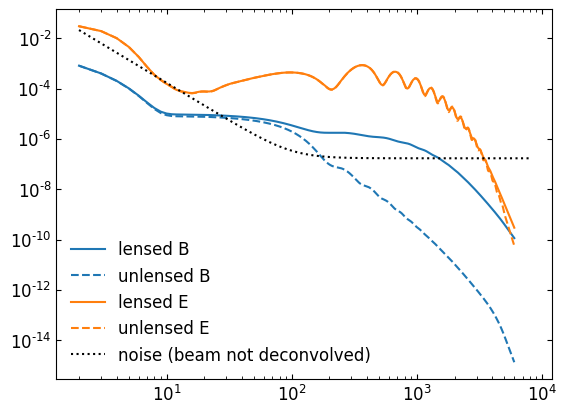

In [5]:
loglog(Cℓ[:f̃][:BB],c="C0")
loglog(Cℓ[:f][:BB],"--",c="C0")
loglog(Cℓ[:f̃][:EE],c="C1")
loglog(Cℓ[:f][:EE],"--",c="C1")
loglog(Cℓn[:BB],"k:")
legend(["lensed B","unlensed B","lensed E","unlensed E", "noise (beam not deconvolved)"]);

## Configure the type of data

These describe the setup of the simulated data we are going to work with (and can be changed),

In [6]:
Θpix  = 3        # pixel size in arcmin
Nside = 128      # number of pixels per side in the map
use   = :P       # type of data to use (can be :T, :P, or :TP)
T     = Float32  # data type (Float32 is ~2 as fast as Float64);

## Generate simulated data

With these defined, the following generates the simulated data and returns the true unlensed and lensed CMB fields, `f` and `f̃` ,and the true lensing potential, `ϕ`, as well as a number of other quantities stored in the "DataSet" object `ds`. 

In [7]:
@unpack f, f̃, ϕ, ds = load_sim_dataset(
    seed = 3,
    Cℓ = Cℓ,
    Cℓn = Cℓn,
    θpix = Θpix,
    T = T,
    Nside = Nside,
    use = use,
)

@unpack Cf, Cϕ = ds;

## Examine simulated data

The true $\phi$ map,

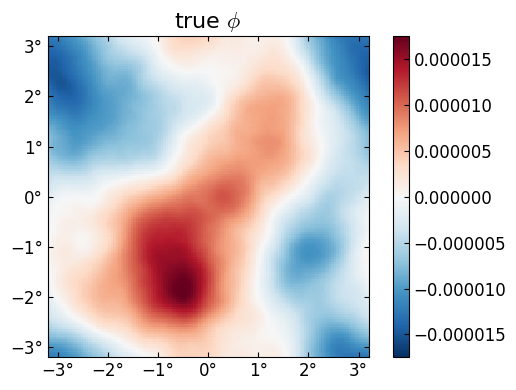

In [8]:
plot(ϕ, title = raw"true $\phi$");

The "true" unlensed field, $f$,

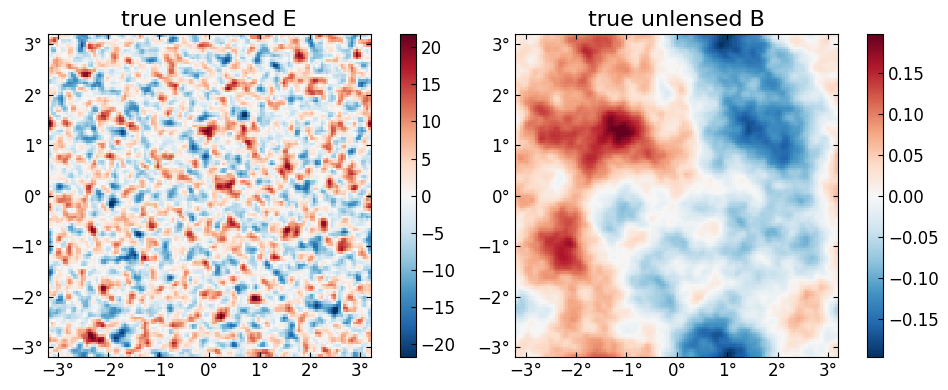

In [9]:
plot(f, title = "true unlensed " .* ["E" "B"]);

And the "true" lensed field,

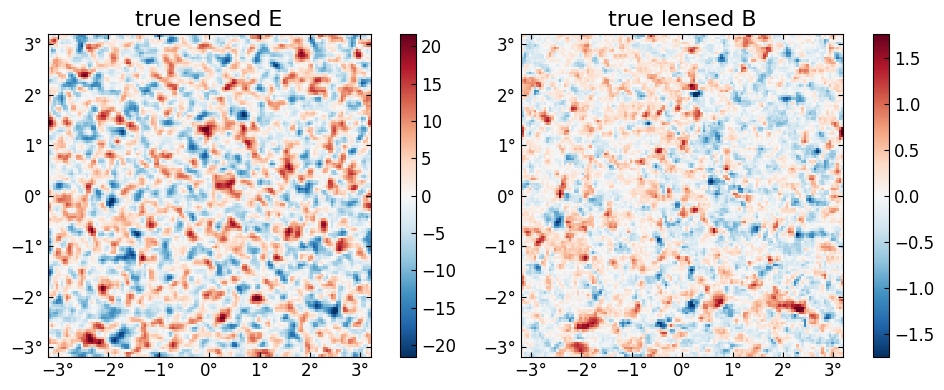

In [10]:
plot(LenseFlow(ϕ)*f, title = "true lensed " .* ["E" "B"]);

The data (stored in the `ds` object) is basically `f̃` with a beam applied plus a sample of the noise,

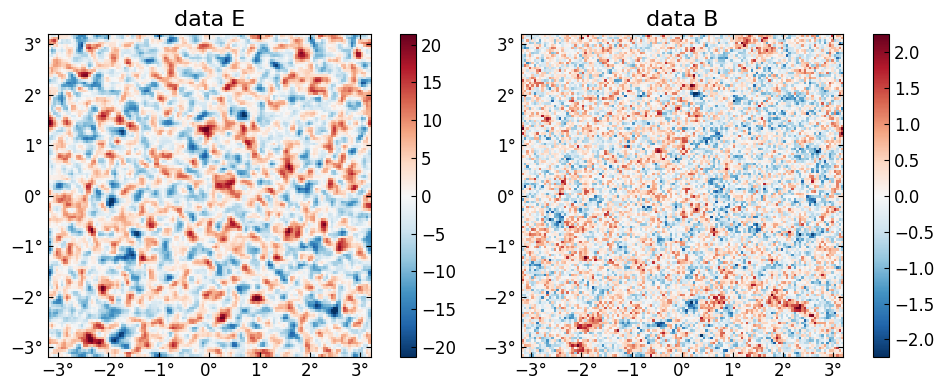

In [11]:
plot(ds.d, title = "data " .* ["E" "B"]);

# Run the minimizer

Now we compute the maximum of the joint posterior, $\mathcal{P}\big(f, \phi \,\big|\,d\big)$

In [20]:
@time fbf, ϕbf, tr = MAP_joint(ds, nsteps=30, progress=:verbose, αmax=0.3);

(step=1, χ²=43095.78, Ncg=5)
(step=2, χ²=37543.46, Ncg=7, α=0.014463)
(step=3, χ²=35741.80, Ncg=6, α=0.023423)
(step=4, χ²=35071.12, Ncg=6, α=0.014308)
(step=5, χ²=34555.13, Ncg=6, α=0.026887)
(step=6, χ²=34267.29, Ncg=6, α=0.012812)
(step=7, χ²=33964.48, Ncg=6, α=0.035907)
(step=8, χ²=33790.90, Ncg=6, α=0.010903)
(step=9, χ²=33509.93, Ncg=6, α=0.068460)
(step=10, χ²=33374.65, Ncg=6, α=0.009032)
(step=11, χ²=32973.32, Ncg=6, α=0.226770)
(step=12, χ²=32909.92, Ncg=5, α=0.008819)
(step=13, χ²=32871.29, Ncg=5, α=0.071585)
(step=14, χ²=32849.00, Ncg=5, α=0.009971)
(step=15, χ²=32774.84, Ncg=5, α=0.238187)
(step=16, χ²=32747.66, Ncg=5, α=0.009445)
(step=17, χ²=32740.30, Ncg=3, α=0.028302)
(step=18, χ²=32734.86, Ncg=3, α=0.027427)
(step=19, χ²=32730.55, Ncg=3, α=0.021647)
(step=20, χ²=32726.88, Ncg=3, α=0.022860)
(step=21, χ²=32723.77, Ncg=3, α=0.017523)
(step=22, χ²=32720.85, Ncg=3, α=0.021248)
(step=23, χ²=32718.26, Ncg=3, α=0.014854)
(step=24, χ²=32715.36, Ncg=3, α=0.026416)
(step=25, χ²=

# Examine results

The expected value of the final best-fit $\chi^2 (=-2\log \mathcal{P}$) is given by the number degrees of freedom in the data, i.e. the total number of pixels in T and/or EB.

In [21]:
χ² = -2tr[end][:lnPcur]

32695.131869109464

In [22]:
dof = getproperty((T=1, P=2, TP=3),use) * Nside^2

32768

Here's how far away our final $\chi^2$ is from this expectation, in units of $\sigma$. We expect this should be somewhere in the range (-3,3) for about 99.7% of simulated datasets.

In [23]:
(χ² - dof)/sqrt(2dof)

-0.2846411362911567

Here's the best-fit $\phi$ relative to the truth,

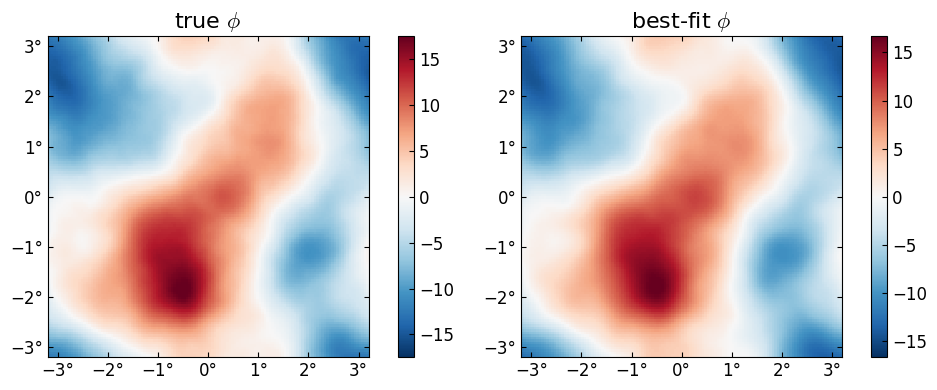

In [24]:
plot(10^6*[ϕ ϕbf], title=["true" "best-fit"] .* raw" $\phi$");

Here is the difference in terms of the power spectra. Note the best-fit has high-$\ell$ power suppressed, like a Wiener filter solution (in fact what we're doing here is akin to a non-linear Wiener filter). In the high S/N region ($\ell\lesssim1000$), the difference is approixmately equal to the noise, which you can see is almost two orders of magnitude below the signal.

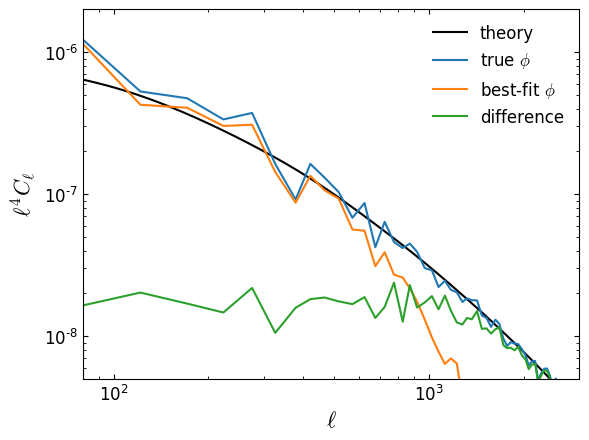

In [25]:
loglog(ℓ⁴ * Cℓ[:f][:ϕϕ], "k")
loglog(ℓ⁴ * get_Cℓ(ϕ))
loglog(ℓ⁴ * get_Cℓ(ϕbf))
loglog(ℓ⁴ * get_Cℓ(ϕbf-ϕ))
xlim(80,3000)
ylim(5e-9,2e-6)
legend(["theory",raw"true $\phi$", raw"best-fit $\phi$", "difference"])
xlabel(raw"$\ell$")
ylabel(raw"$\ell^4 C_\ell$");

The best-fit unlensed fields relative to truth,

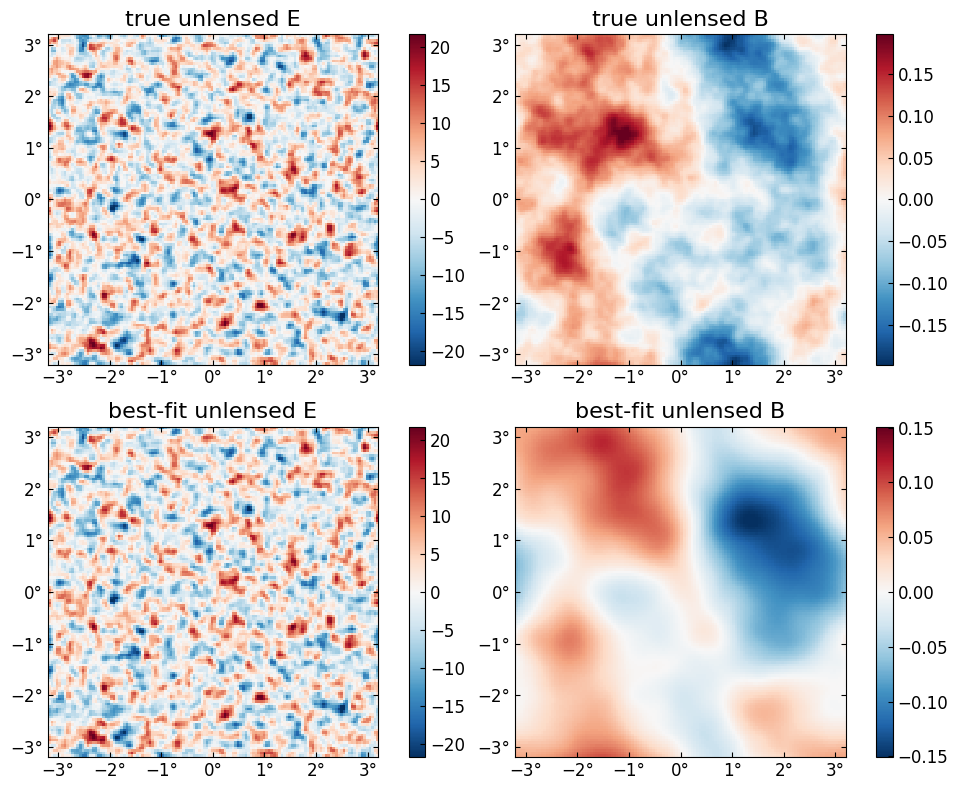

In [26]:
plot([f,fbf], title = ["true", "best-fit"] .* " unlensed " .* ["E" "B"]);

The best-fit lensed field (bottom row) relative to truth (top row),

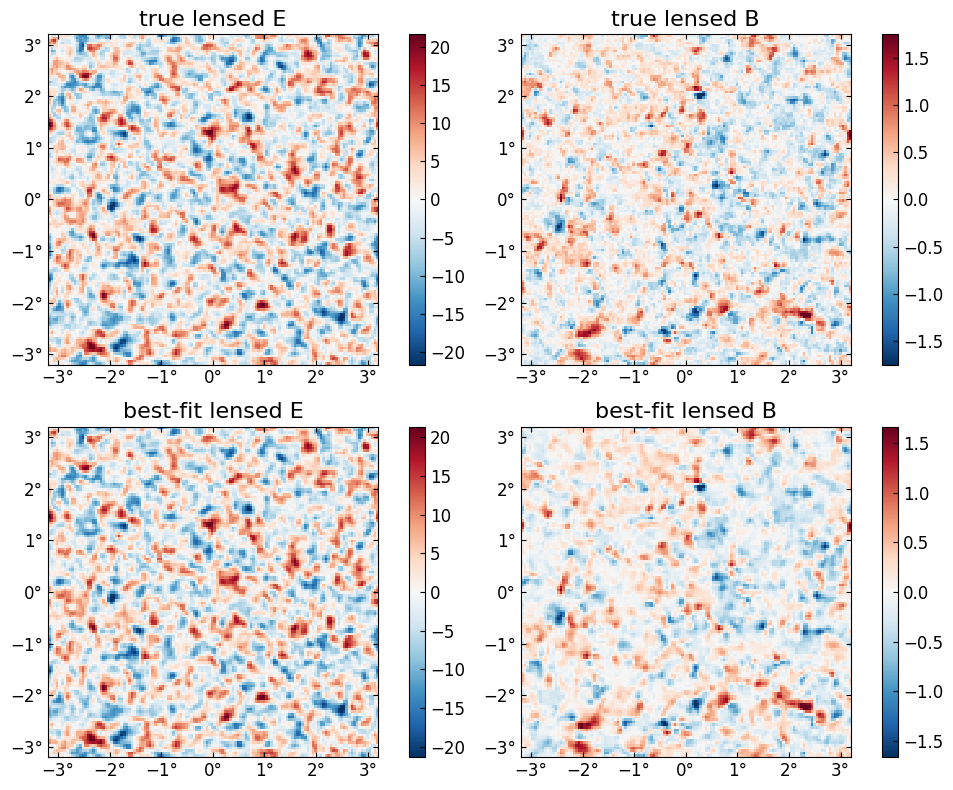

In [27]:
plot([f̃, LenseFlow(ϕbf)*fbf], title = ["true", "best-fit"] .* " lensed " .* ["E" "B"]);